In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Latent Diffusion Training

In this notebook, we will train a simple `LatentDiffusion` model.

The training should take up to 20 hours for reasonable results.


In [2]:
import os, sys, argparse
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import seed_everything

import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio

from src import *

mpl.rcParams['figure.figsize'] = (8, 8)
sys.argv = ['ipykernel_launcher.py']

In [3]:
# Note: Actually it's totally unnecessay and silly to use argparse in jupyter notebook. 
# But anyway, it's a good chance to do some practice and it will definitey be useful someday.
parser = argparse.ArgumentParser()
parser.add_argument("--image_size", type=int, default=256, help="Image size")
parser.add_argument("--train_dataset", type=str, default="/mnt/afhq/", help="The path to your training dataset")
parser.add_argument("--device", type=str, default=0 if torch.cuda.is_available() else "cpu", help="Device number.")
parser.add_argument("--num_workers", type=int, default=3, help="Spawn how many processes to load data.")
parser.add_argument("--seed", type=int, default=42, help='manual seed')
parser.add_argument("--max_epochs", type=int, default=1000, help="Max epoch number to run.")
parser.add_argument("--ckpt_path", type=str, default="/mnt/ckpt/epoch=100-step=184729.ckpt", help="Checkpoint path to load.")
parser.add_argument("--save_path", type=str, default="/mnt/ckpt/", help="Checkpoint path to save.")
parser.add_argument("--save_freq", type=int, default=1, help="Save model every how many epochs.")
parser.add_argument("--ddim_steps", type=int, default=50, help="DDIM timesteps")
# TODO begin: Add arguments lr and batch_size. It's recommended to set default lr to 1e-4 and default batch_size to 8.
parser.add_argument("--lr", type=float, default=1e-4, help="learning rate")
parser.add_argument("--batch_size", type=int, default=8, help="batch size")
# TODO end
args = parser.parse_args()
seed_everything(args.seed)

Global seed set to 42


42

In [4]:
from kornia.utils import image_to_tensor
import kornia.augmentation as KA

class SimpleImageDataset(Dataset):
    """Dataset returning images in a folder."""

    def __init__(self,
                 root_dir,
                 transforms = None):

        self.root_dir = root_dir
        self.transforms = transforms

        # set up transforms
        if self.transforms is not None:
            data_keys = ['input']

            self.input_T = KA.container.AugmentationSequential(
                *self.transforms,
                data_keys = data_keys,
                same_on_batch = False
            )

        # TODO begin: Define the image paths filtered by the `supported_formats` in your datasets
        # Hint: os.listdir
        # Challenge: Can you complete this task in one line? (hint: Python comprehension, refer to Python basics handout by Yifan Li)
        supported_formats = ["jpg", "png"]
        self.image_names = [i for i in os.listdir(self.root_dir) if i[-3:] in supported_formats]
        # TODO end

    def __len__(self):
        # TODO begin: Return the length of your dataset
        return len(self.image_names)
        # TODO end

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_names[idx])
        image = image_to_tensor(imageio.imread(img_name)) / 255

        if self.transforms is not None:
            image = self.input_T(image)[0]

        return image


In [5]:
import torchvision.transforms as T

CROP_SIZE = args.image_size

transform = [
    KA.RandomCrop((2 * CROP_SIZE,2 * CROP_SIZE)),
    KA.Resize((CROP_SIZE, CROP_SIZE), antialias=True),
    KA.RandomVerticalFlip()
  ]

train_dataset = SimpleImageDataset(args.train_dataset, transforms = transform)


In [6]:
# TODO begin: Define the training dataloader using torch.utils.data.DataLoader
# Hint: check the API of torch.utils.data.DataLoader, especially arguments like batch_size, shuffle, num_workers
train_dataloader = DataLoader(train_dataset, 
                              batch_size=args.batch_size, 
                              shuffle=True, 
                              num_workers=args.num_workers)
# TODO end

### Model Training

In [7]:
from src import *

# TODO begin: complete the LatentDiffusion Model in `src`
# I downloaded the model locally in advance, actually you can remove the param 'vae_model_type'
model = LatentDiffusion(lr = args.lr, batch_size = args.batch_size, vae_model_type='/mnt/sd-vae-ft-ema')
# TODO end

Is Time embed used ?  True


...but first, let's check if the used `AutoEncoder` (`model.vae`) can reconstruct our samples well.

**You should always test your autoencoder in this way when using latent diffusion models on a new dataset.**

/tmp/ipykernel_542/1146272304.py:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = image_to_tensor(imageio.imread(img_name)) / 255
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


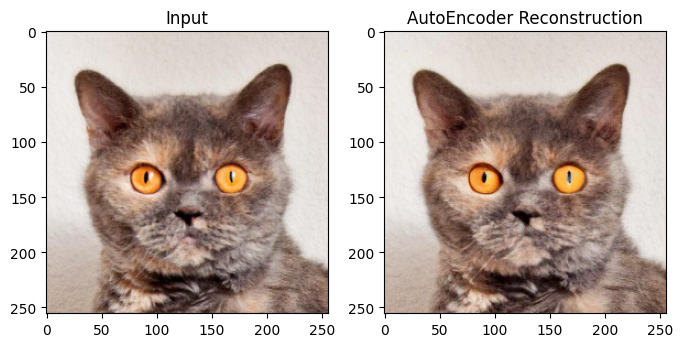

In [8]:
img = train_dataset[0]

# TODO begin: Show the example img and use vae to reconstruct it using matplotlib
# Hint: plt.imshow
# Challenge: What's the image shape here? Should you permute or unsqueeze it?
plt.subplot(1,2,1)
# Plot the original img here
plt.imshow(img.permute(1,2,0))
plt.title('Input')

plt.subplot(1,2,2)
# Plot the reconstructed img by `mode.vae` here
plt.imshow(model.vae(img.unsqueeze(dim=0)).squeeze(dim=0).permute(1,2,0))
plt.title('AutoEncoder Reconstruction')
plt.show();
# TODO end

In [9]:
# Define the trainer using PyTorch Lightning
# Note that here need to change package's name, or get a ValueError:Expected a parent
from pytorch_lightning.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(dirpath=args.save_path, every_n_epochs=args.save_freq)

# TODO: Can you add some logging and visualization codes to better babysitting the training process? 
# Hint: There are many librarys you can use, e.g. logging, tensorboard, wandb... And the easiest way: print the loss every step.
logger = TensorBoardLogger(save_dir='/mnt/', version=1, name="lightning_logs")

# TODO: You can specify other parameters here, like accelerator, devices...
# You can check the pl.Trainer API here: https://lightning.ai/docs/pytorch/stable/common/trainer.html
trainer = pl.Trainer(
    max_epochs = args.max_epochs,
    callbacks = [EMA(0.9999), checkpoint_callback],
    accelerator='gpu', 
    logger=logger
)

/mnt/src/EMA.py:58: UserWarning: EMA has better performance when Apex is installed: https://github.com/NVIDIA/apex#installation.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
# Easy to train the model in PyTorch Lightning in one line
trainer.fit(model, train_dataloaders=train_dataloader, ckpt_path=args.ckpt_path if args.ckpt_path else None)

/root/miniconda3/envs/myconda/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | vae   | AutoEncoder               | 83.7 M
1 | model | DenoisingDiffusionProcess | 56.6 M
----------------------------------------------------
56.6 M    Trainable params
83.7 M    Non-trainable params
140 M     Total params
561.084   Total estimated model params size (MB)
/tmp/ipykernel_542/1146272304.py:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = image_to_tensor(imageio.imread(img_name)) / 255
/

Training: 0it [00:00, ?it/s]

/tmp/ipykernel_542/1146272304.py:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = image_to_tensor(imageio.imread(img_name)) / 255
/tmp/ipykernel_542/1146272304.py:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = image_to_tensor(imageio.imread(img_name)) / 255
/tmp/ipykernel_542/1146272304.py:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = image_to_tensor(

Go to sleep now ~ This one line might run for days...

Wait! Please make sure that you have save the checkpoints correctly.

If the code breaks for some reason, you can load the checkpoint and continue training.

### Now sample images from your model!

In [11]:
# load model
model = LatentDiffusion.load_from_checkpoint(args.ckpt_path)

Is Time embed used ?  True


In [12]:
model.to(args.device)
out = model(batch_size = args.batch_size, shape = (64,64), verbose = True)
# You can also try `sampler=DDIM_Sampler(num_steps=args.ddim_steps)`, which can sample images in less than 50 steps.

diffusion sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


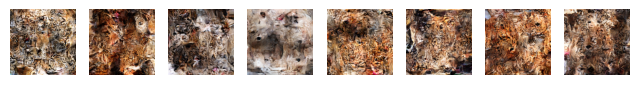

In [13]:
for idx in range(out.shape[0]):
    plt.subplot(1, len(out), idx+1)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')